In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
#from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt

## 1. 데이터 불러오기

### Boston Housing Dataset

- 보스턴 주택 가격 데이터
- 1978년에 발표된 데이터로 미국 보스턴 지역의 주택 가격에 영향을 미치는 요소들을 정리
- 총 13가지의 요소들과 주택 가격으로 이루어져 있음.

### 데이터 호출

In [2]:
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]
column_names = ['CRM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']

### 데이터 분할
- Training set 70%, Test set 30% 무작위 추출을 이용하여 나누기


In [18]:
X_train, X_test, y_train, y_test = \
train_test_split(X_boston, y_boston,
                 test_size = 0.3, random_state=123)

## 2. 앙상블

### 2.0 Decision Tree

In [19]:
tree = DecisionTreeRegressor(max_depth = 5,    #아래 그림이 나오게 빈칸에 의사결정나무 함수 작성
                             random_state = 0)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

### 예측

In [20]:
tree_pred = tree.predict(X_test)
print(np.power(y_test-tree_pred,2).mean())

17.602204873990754


### 2.1 Bagging

### 모형적합

In [21]:
tree = DecisionTreeRegressor()
bag_model = BaggingRegressor(tree, n_estimators=1000,
                             max_samples=0.8, random_state=1)
bag_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_samples=0.8,
                 n_estimators=1000, random_state=1)

### 예측

In [22]:
bag_pred = bag_model.predict(X_test)
print(np.mean(np.abs(y_test - bag_pred)))  #MAE 계산식 작성 (모르겠으면 위에꺼 참고)

2.3376190789473736


### 2.2 Random Forest

### 모형적합

In [31]:
rf_model = RandomForestRegressor(n_estimators=1000,  #아래 그림처럼 나오게 하이퍼파라미터 작성
                                 max_features=3,
                                 min_samples_leaf=3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=3, min_samples_leaf=3, n_estimators=1000)

### 예측

In [32]:
rf_pred = rf_model.predict(X_test)
print(np.power(y_test - rf_pred, 2).mean()) #MSE계산식 작성

16.436586445431217


### 2.3 Boosting

### 모형적합

In [33]:
gbm_model = GradientBoostingRegressor(n_estimators=1000,  #그래디언트부스팅함수 작성
                                      max_depth=3)
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=1000)

### 예측

In [34]:
gbm_pred = gbm_model.predict(X_test)
print(np.power(y_test-gbm_pred,2).mean())

13.318271710368196


### Partial Dependence Plot

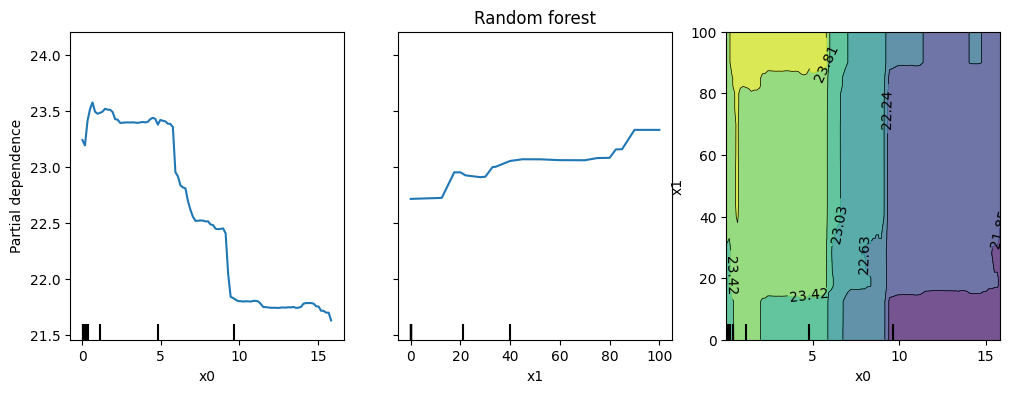

In [35]:
#from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Random forest', fontsize=12)
tree_disp = PartialDependenceDisplay.from_estimator(rf_model, X_train, [0,1,[0,1]], ax=ax)

### 각 그래프를 해석하시오
1.x0 값이 증가할수록 모델의 예측값(부분 의존성 값)이 감소하는 경향을 보인다.특히 x0 ≈ 5 부근에서 급격한 하락이 발생하는데, 이는 x0 값이 특정 구간을 넘어가면 모델의 예측값이 크게 감소함을 시사한다.

2.x1 값이 증가할수록 모델의 예측값이 점진적으로 증가하는 패턴을 보인다. 이는 x1이 클수록 모델이 예측하는 값도 커지는 양의 상관관계를 의미한다. x1이 특정 구간(약 40~80)에서 완만하게 증가하는 패턴을 보이지만, 그 이후로 다시 변동하는 모습을 보인다.

3.x0 및 x1 조합에서 예측값이 변하는 패턴을 확인할 수 있다. x0가 작은 경우 x1이 클수록 모델의 예측값이 높아지는 경향을 보이고, x0이 특정 값 이상 (10 이상)이 되면 x1의 변화가 모델의 예측값에 큰 영향을 미치지 않는다.

### Variable Importance Plot

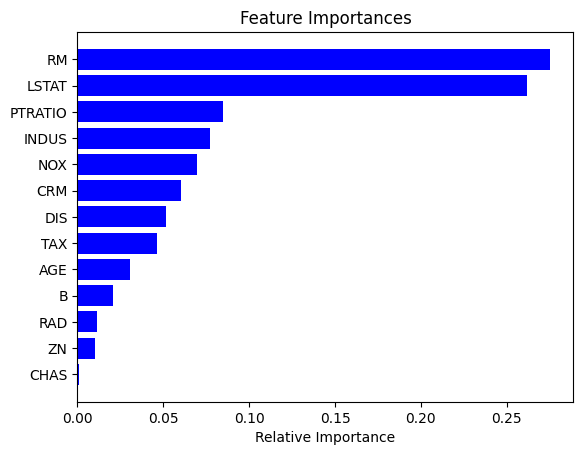

In [36]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [column_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()